*The purpose of this notebook is to train, evaluate, and tune ML regression models for our problem*

### Tested models :

**Baseline dummy regressor** :

- RMSE=0.445, std=0.016

**Linear regression** :

- RMSE=0.230, std=0.010
- doing better than baseline. isues : from residuals we see that the model predict wrongly 3 specific range of values between ~ 500 000 and ~ 1M$ cost. not so good either > 1M $ 
- struggle to find linear relationship between explanatory variables and target

**Linear lasso regression** :

- tunned cv param : ```alpha=0.0005```
- RMSE = 0.223, std=0.009
- small score improvments, this regularization didn't solve the issues mentioned above

**Linear ridge regression** :

- tunned cv param : ```alpha=15``` 
- RMSE = 0.230, std=0.010
- no score improvments, this regularization didn't solve the issue mentioned above either

*linear regression models are not conclusive, moving on to regression trees*

**Random forest regressor**

-



# Setup

Import sklearn tools and data vizualisation libraries

In [54]:
import numpy as np
import pandas as pd
import joblib

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error,mean_squared_error,mean_squared_log_error,mean_absolute_error,explained_variance_score
import xgboost as xgb
import lightgbm as lgb
from sklearn.svm import SVC

import sys #importing local functions in src folder
sys.path.append('../src/')
from functions import cross_validate_score, score_ML_log

pd.options.display.max_columns = None
pd.options.display.max_rows = None

import warnings
warnings.filterwarnings('ignore')

sns.set()

# Import Dataset

We use a cleaned version of the original Building Permits dataset : cleaned NaN, cleaned outliers, added 'building ground surface area' feature, feature engineering

In [3]:
dataset_url = 'https://drive.google.com/file/d/1Ffbhy12m4JG9REEdSQwwewIFE0KUiEX3/view?usp=sharing'
dataset_url ='https://drive.google.com/uc?id=' + dataset_url.split('/')[-2]

dataset = pd.read_csv(dataset_url)

In [4]:
dataset.shape

(6575, 62)

In [5]:
dataset.head()

,Permit Number,Permit Type,Permit Type Definition,Permit Creation Date,Block,Lot,Street Number,Street Name,Street Suffix,Description,Current Status,Current Status Date,Filed Date,Issued Date,Completed Date,First Construction Document Date,Number of Proposed Stories,Permit Expiration Date,Estimated Cost,Revised Cost,Proposed Use,Proposed Units,Plansets,Proposed Construction Type,Proposed Construction Type Description,Site Permit,Supervisor District,Neighborhoods - Analysis Boundaries,Zipcode,Location,Record ID,address,lat,lon,Duration_construction_days,Process_time_days,Year,Est_Cost_Infl,Rev_Cost_Infl,Est_Cost_Infl_log10,Est_Cost_Infl_loge,lat_lon,address.1,geometry,point,polygon,area_m2,Number of Proposed Stories_,Number of Proposed Stories_cat,Zipcode_,Proposed Construction Type_,Number of Proposed Stories_cat_f,Proposed Use_f,Proposed Construction Type_f,Number of Proposed Stories_bct,Number of Proposed Stories_cat_f_bct,Proposed Construction Type_f_bct,Proposed Units_bct,Proposed Use_f_bct,Duration_construction_days_bct,total_area_m2,cost_per_m2
0,9111378,2,new construction wood frame,1991-06-28,3566,037,3686,17th,St,erect a four story three unit residential bldg,complete,1993-09-20,1991-06-28,1992-11-30,1993-09-20,NaN,4.0,1994-11-30,250000.0,350000.0,apartments,3.0,2.0,5,wood frame (5),NaN,8.0,Castro/Upper Market,94114,POINT (-122.42798037718552 37.76316610254898),342335281878,3686 17th St,-122.427980,37.763166,294.0,521.0,1991,4.973752e+05,696325.256975,5.696684,13.117100,-4623.268159,"3686 17th St, San Francisco, CA 94114",NaN,POINT (-122.42798037718552 37.76316610254898),"POLYGON ((6004384.44156398 2106033.407080037, ...",147.915331,4.0,3-4 stories,94114,5,0,0,0,1.746189,0.0,0.0,1.486984,0.000000,7.659654,591.661324,840.641704
1,8707430,2,new construction wood frame,1987-05-29,1733,046,1254,18th,Av,NaN,complete,1988-10-07,1987-05-29,1988-01-20,1988-10-07,NaN,3.0,1990-01-20,394000.0,NaN,apartments,4.0,2.0,5,wood frame (5),NaN,4.0,Inner Sunset,94122,POINT (-122.47578567375196 37.76447248121622),161612112132,1254 18th Av,-122.475786,37.764472,261.0,236.0,1987,9.398079e+05,NaN,5.973039,13.753431,-4625.233438,"1254 18th Av, San Francisco, CA 94122","{""type"": ""Polygon"", ""coordinates"": [[[-122.476...",POINT (-122.47578567375196 37.76447248121622),"POLYGON ((5990594.490913103 2106871.242348627,...",253.922359,3.0,3-4 stories,94122,5,0,0,0,1.486984,0.0,0.0,1.746189,0.000000,7.451394,761.767077,1233.720846
2,7912377,2,new construction wood frame,1979-12-01,1361,064,3900,California,St,NaN,complete,1984-02-29,1979-12-01,1983-01-24,1984-02-29,NaN,3.0,1985-01-24,790000.0,NaN,apartments,8.0,2.0,5,wood frame (5),NaN,2.0,Inner Richmond,94118,POINT (-122.45952470081986 37.7858592269433),86903496726,3900 California St,-122.459525,37.785859,401.0,1150.0,1979,2.948572e+06,NaN,6.469612,14.896831,-4627.238361,"3900 California St, San Francisco, CA 94118","{""type"": ""Polygon"", ""coordinates"": [[[-122.459...",POINT (-122.45952470081986 37.7858592269433),POLYGON ((5995398.966155565 2114500.1454920806...,504.669823,3.0,3-4 stories,94118,5,0,0,0,1.486984,0.0,0.0,2.457309,0.000000,8.214724,1514.009469,1947.525221
3,8010466,2,new construction wood frame,1980-11-25,4159,074,1084,De Haro,St,NaN,complete,1985-07-05,1980-11-25,1984-08-06,1985-07-05,NaN,3.0,1985-08-06,210500.0,NaN,2 family dwelling,2.0,4.0,5,wood frame (5),NaN,10.0,Potrero Hill,94107,POINT (-122.40107686660524 37.7560791545319),1490171598,1084 De Haro St,-122.401077,37.756079,333.0,1350.0,1980,6.922231e+05,NaN,5.840246,13.447664,-4621.384747,"1084 De Haro St, San Francisco, CA 94107",NaN,POINT (-122.40107686660524 37.7560791545319),POLYGON ((6012157.402672291 2103366.9430118585...,167.842843,3.0,3-4 stories,94107,5,0,1,0,1.486984,0.0,0.0,1.161232,0.717735,7.880294,503.528529,1374.744586
4,8010466,2,new construction wood frame,1980-11-25,4159,073,1082,De Haro,St,NaN,complete,1985-07-05,1980-11-25,1984-08-06,1985-07-05,NaN,3.0,1985-08-06,210500.0,NaN,2 family dwelling,2.0,4.0,5,

In [6]:
dataset.columns

Index(['Permit Number', 'Permit Type', 'Permit Type Definition',
       'Permit Creation Date', 'Block', 'Lot', 'Street Number', 'Street Name',
       'Street Suffix', 'Description', 'Current Status', 'Current Status Date',
       'Filed Date', 'Issued Date', 'Completed Date',
       'First Construction Document Date', 'Number of Proposed Stories',
       'Permit Expiration Date', 'Estimated Cost', 'Revised Cost',
       'Proposed Use', 'Proposed Units', 'Plansets',
       'Proposed Construction Type', 'Proposed Construction Type Description',
       'Site Permit', 'Supervisor District',
       'Neighborhoods - Analysis Boundaries', 'Zipcode', 'Location',
       'Record ID', 'address', 'lat', 'lon', 'Duration_construction_days',
       'Process_time_days', 'Year', 'Est_Cost_Infl', 'Rev_Cost_Infl',
       'Est_Cost_Infl_log10', 'Est_Cost_Infl_loge', 'lat_lon', 'address.1',
       'geometry', 'point', 'polygon', 'area_m2',
       'Number of Proposed Stories_', 'Number of Proposed Stories

In [7]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6575 entries, 0 to 6574
Data columns (total 62 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Permit Number                           6575 non-null   object 
 1   Permit Type                             6575 non-null   int64  
 2   Permit Type Definition                  6575 non-null   object 
 3   Permit Creation Date                    6575 non-null   object 
 4   Block                                   6575 non-null   object 
 5   Lot                                     6575 non-null   object 
 6   Street Number                           6575 non-null   int64  
 7   Street Name                             6575 non-null   object 
 8   Street Suffix                           6575 non-null   object 
 9   Description                             5587 non-null   object 
 10  Current Status                          6575 non-null   obje

# Feature Selection

Features are selected manually based on their relevance and/or strong correlation with the target. We end up with 4 numeric features and 3 categorical features

<AxesSubplot:>

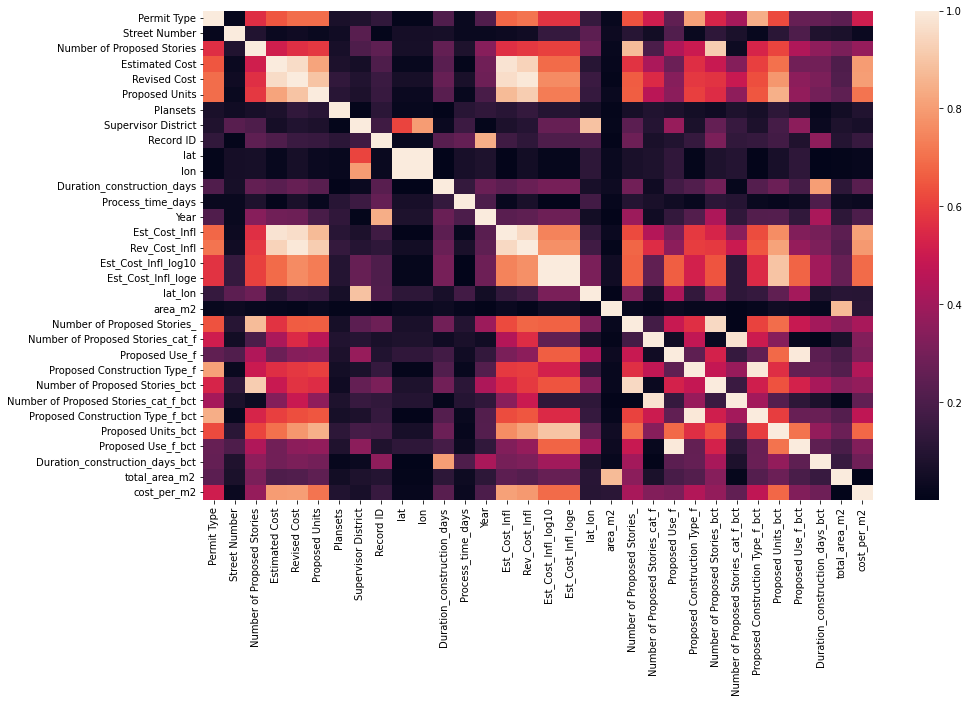

In [8]:
# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(15, 9))
sns.heatmap(dataset.corr(method='pearson').abs(), annot=False, ax=ax)

### Target Info

- **Est_Cost_Infl_log10** : estimated construction cost of a building taking inflation into account and converted into log10

### Feature Info

- **Permit Type** : type of permit
- **Proposed Units** : number of units built
- **Number of Proposed Stories_**: number of stories built
- **Proposed Use** : type of use
- **Proposed Construction Type_** : fire resistance rating (building structure)
- **lat_lon** : coordinates of the building (latitude * longitude)
- **total_area_m2** : building ground surface area * number of stories


In [9]:
dataset.head()

,Permit Number,Permit Type,Permit Type Definition,Permit Creation Date,Block,Lot,Street Number,Street Name,Street Suffix,Description,Current Status,Current Status Date,Filed Date,Issued Date,Completed Date,First Construction Document Date,Number of Proposed Stories,Permit Expiration Date,Estimated Cost,Revised Cost,Proposed Use,Proposed Units,Plansets,Proposed Construction Type,Proposed Construction Type Description,Site Permit,Supervisor District,Neighborhoods - Analysis Boundaries,Zipcode,Location,Record ID,address,lat,lon,Duration_construction_days,Process_time_days,Year,Est_Cost_Infl,Rev_Cost_Infl,Est_Cost_Infl_log10,Est_Cost_Infl_loge,lat_lon,address.1,geometry,point,polygon,area_m2,Number of Proposed Stories_,Number of Proposed Stories_cat,Zipcode_,Proposed Construction Type_,Number of Proposed Stories_cat_f,Proposed Use_f,Proposed Construction Type_f,Number of Proposed Stories_bct,Number of Proposed Stories_cat_f_bct,Proposed Construction Type_f_bct,Proposed Units_bct,Proposed Use_f_bct,Duration_construction_days_bct,total_area_m2,cost_per_m2
0,9111378,2,new construction wood frame,1991-06-28,3566,037,3686,17th,St,erect a four story three unit residential bldg,complete,1993-09-20,1991-06-28,1992-11-30,1993-09-20,NaN,4.0,1994-11-30,250000.0,350000.0,apartments,3.0,2.0,5,wood frame (5),NaN,8.0,Castro/Upper Market,94114,POINT (-122.42798037718552 37.76316610254898),342335281878,3686 17th St,-122.427980,37.763166,294.0,521.0,1991,4.973752e+05,696325.256975,5.696684,13.117100,-4623.268159,"3686 17th St, San Francisco, CA 94114",NaN,POINT (-122.42798037718552 37.76316610254898),"POLYGON ((6004384.44156398 2106033.407080037, ...",147.915331,4.0,3-4 stories,94114,5,0,0,0,1.746189,0.0,0.0,1.486984,0.000000,7.659654,591.661324,840.641704
1,8707430,2,new construction wood frame,1987-05-29,1733,046,1254,18th,Av,NaN,complete,1988-10-07,1987-05-29,1988-01-20,1988-10-07,NaN,3.0,1990-01-20,394000.0,NaN,apartments,4.0,2.0,5,wood frame (5),NaN,4.0,Inner Sunset,94122,POINT (-122.47578567375196 37.76447248121622),161612112132,1254 18th Av,-122.475786,37.764472,261.0,236.0,1987,9.398079e+05,NaN,5.973039,13.753431,-4625.233438,"1254 18th Av, San Francisco, CA 94122","{""type"": ""Polygon"", ""coordinates"": [[[-122.476...",POINT (-122.47578567375196 37.76447248121622),"POLYGON ((5990594.490913103 2106871.242348627,...",253.922359,3.0,3-4 stories,94122,5,0,0,0,1.486984,0.0,0.0,1.746189,0.000000,7.451394,761.767077,1233.720846
2,7912377,2,new construction wood frame,1979-12-01,1361,064,3900,California,St,NaN,complete,1984-02-29,1979-12-01,1983-01-24,1984-02-29,NaN,3.0,1985-01-24,790000.0,NaN,apartments,8.0,2.0,5,wood frame (5),NaN,2.0,Inner Richmond,94118,POINT (-122.45952470081986 37.7858592269433),86903496726,3900 California St,-122.459525,37.785859,401.0,1150.0,1979,2.948572e+06,NaN,6.469612,14.896831,-4627.238361,"3900 California St, San Francisco, CA 94118","{""type"": ""Polygon"", ""coordinates"": [[[-122.459...",POINT (-122.45952470081986 37.7858592269433),POLYGON ((5995398.966155565 2114500.1454920806...,504.669823,3.0,3-4 stories,94118,5,0,0,0,1.486984,0.0,0.0,2.457309,0.000000,8.214724,1514.009469,1947.525221
3,8010466,2,new construction wood frame,1980-11-25,4159,074,1084,De Haro,St,NaN,complete,1985-07-05,1980-11-25,1984-08-06,1985-07-05,NaN,3.0,1985-08-06,210500.0,NaN,2 family dwelling,2.0,4.0,5,wood frame (5),NaN,10.0,Potrero Hill,94107,POINT (-122.40107686660524 37.7560791545319),1490171598,1084 De Haro St,-122.401077,37.756079,333.0,1350.0,1980,6.922231e+05,NaN,5.840246,13.447664,-4621.384747,"1084 De Haro St, San Francisco, CA 94107",NaN,POINT (-122.40107686660524 37.7560791545319),POLYGON ((6012157.402672291 2103366.9430118585...,167.842843,3.0,3-4 stories,94107,5,0,1,0,1.486984,0.0,0.0,1.161232,0.717735,7.880294,503.528529,1374.744586
4,8010466,2,new construction wood frame,1980-11-25,4159,073,1082,De Haro,St,NaN,complete,1985-07-05,1980-11-25,1984-08-06,1985-07-05,NaN,3.0,1985-08-06,210500.0,NaN,2 family dwelling,2.0,4.0,5,

In [10]:
# Separate target variable Y from features X
print("Separating labels from features...")
features_list =[
    'Permit Type',
    'Proposed Units',
    'Number of Proposed Stories_',
    'Proposed Use',
    'Proposed Construction Type_',
    'lat_lon',
    'total_area_m2'
    ]

target_variable = "Est_Cost_Infl_log10"

X = dataset.loc[:,features_list]
Y = dataset.loc[:,target_variable]

print("...Done.")
print()

print('Y : ')
print(Y.head())
print()
print('X :')
print(X.head())

Separating labels from features...
...Done.

Y : 
0    5.696684
1    5.973039
2    6.469612
3    5.840246
4    5.840246
Name: Est_Cost_Infl_log10, dtype: float64

X :
   Permit Type  Proposed Units  Number of Proposed Stories_  \
0            2             3.0                          4.0   
1            2             4.0                          3.0   
2            2             8.0                          3.0   
3            2             2.0                          3.0   
4            2             2.0                          3.0   

        Proposed Use Proposed Construction Type_      lat_lon  total_area_m2  
0         apartments                           5 -4623.268159     591.661324  
1         apartments                           5 -4625.233438     761.767077  
2         apartments                           5 -4627.238361    1514.009469  
3  2 family dwelling                           5 -4621.384747     503.528529  
4  2 family dwelling                           5 -4621.3847

In [11]:
#Manually selecting type of features
numeric_features=[
    'Proposed Units',
    'Number of Proposed Stories_',
    'lat_lon',
    'total_area_m2'
    ]

categorical_features=[
    'Proposed Use',
    'Permit Type',
    'Proposed Construction Type_'
    ] 

## **Preprocessor**

- Numeric features : standardizing, scaling, replacing remaining missing values by columns' mean

- Categorical features : one hot encoding as they are nominals

In [12]:
# Create pipeline for numeric features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), # missing values will be replaced by columns' mean
    ('scaler', StandardScaler())
])

# Create pipeline for categorical features
categorical_transformer = Pipeline(
    steps=[
    ('encoder', OneHotEncoder(drop='first')) # first column will be dropped to avoid creating correlations between features
    ])

# Use ColumnTransformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

## **Defining training/test sets**

Using the train_test_split function, we separate our dataset regarding 80% training data and 20% test data

In [13]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=0)

print("Preprocessing X_train...")
print()
X_train = preprocessor.fit_transform(X_train)
print("...Done!")
print(X_train[0:5,:]) # X_train is now a numpy array
print()

# Test pipeline
print("Preprocessing X_test...")
print()
X_test = preprocessor.transform(X_test) # Don't fit again !! The test set is used for validating decisions
# we made based on the training set, therefore we can only apply transformations that were parametered using the training set.
# Otherwise this creates what is called a leak from the test set which will introduce a bias in all your results.
print("...Done!")
print(X_test[0:5,:]) # X_test is now a numpy array
print()

Y_train = Y_train.to_numpy()
Y_test = Y_test.to_numpy()

Preprocessing X_train...

...Done!
[[-0.29038835 -0.84520684  0.93761135 -0.46635782  0.          0.
   1.          0.          0.          1.          0.        ]
 [-0.24227082 -0.02819168 -0.69856192 -0.07607803  1.          0.
   1.          0.          0.          1.          0.        ]
 [ 0.09455185  0.78882348 -1.63461302 -0.43950711  0.          1.
   1.          0.          0.          1.          0.        ]
 [-0.29038835 -0.84520684  1.03033759 -0.63465029  0.          0.
   1.          0.          0.          1.          0.        ]
 [-0.29038835 -0.02819168  0.27604726  0.09656771  0.          0.
   1.          0.          0.          1.          0.        ]]

Preprocessing X_test...

...Done!
[[-0.29038835 -0.02819168  1.44836085 -0.54837014  0.          0.
   1.          0.          0.          1.          0.        ]
 [-0.24227082 -0.02819168 -0.87929061 -0.36044652  1.          0.
   1.          0.          0.          1.          0.        ]
 [-0.04980072  0.78882348 

## Metric, evalutation process

We use the root mean squared error (RMSE) to assess the performance of the models.<br>
Since the construction costs target has undergone a log10 transformation, computing a RMSE score actually returns the root mean squared log error (RMSLE).<br>
RMLSE in preferable in our case because we care about percentage errors rather than the absolute value of errors and we don’t want to penalize big differences<br>
when both the predicted cost and the actual cost are big numbers.<br>
We use the ```cross_val_score``` function of sklearn to evaluate a score by cross-validation.<br>
Then, we use the function ```Kfold``` where ```shuffle = True``` to allow a shuffle attribution
as ```cross_val_score``` does not have this option.

In [14]:
#root mean squared error for 5-folds cross validation
def rmse_cv(model, x, y):
    random_state = 84
    n_folds = 5
    kf = KFold(n_folds, shuffle=True, random_state=random_state).get_n_splits(X_train)
    rmse= np.sqrt(-cross_val_score(model, x, y, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

## Baseline regressor

Computing RMSE cross validation score for a dummy model that would systematically predict the mean target value.
We want to know if our models are performing against a baseline in order to improve them.

In [15]:
poor_predictions_scores = []

for test_fold in np.split(Y_train, 5):
    mean_value_vector = np.full(len(test_fold), Y_train.mean())
    score = mean_squared_error(y_true = test_fold, y_pred= mean_value_vector ,squared = False)
    poor_predictions_scores.append(score)

poor_predictions_scores = np.array(poor_predictions_scores)
print("poor predictions score : RMSE = {} with a standard deviation of {}".format(poor_predictions_scores.mean(), poor_predictions_scores.std()))

poor predictions score : RMSE = 0.4450709023736894 with a standard deviation of 0.01587663260410946


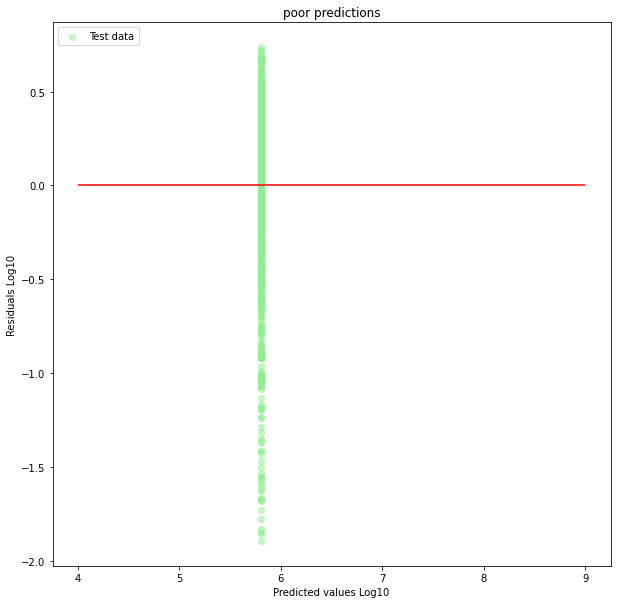

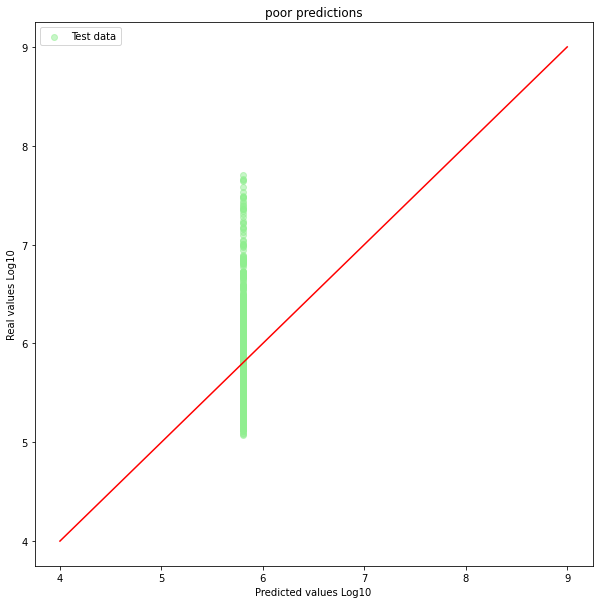

In [16]:
mean_value_vector = np.full(len(Y_test), Y_train.mean())

# Plot residuals
plt.figure(figsize=(10, 10))
#plt.scatter(Y_train_pred, Y_train_pred - Y_train, c = "blue", marker = "o", alpha=0.5, label = "Training data")
plt.scatter(mean_value_vector, mean_value_vector - Y_test, c = "lightgreen", marker = "o", alpha=0.5, label = "Test data")
plt.title("poor predictions")
plt.xlabel("Predicted values Log10")
plt.ylabel("Residuals Log10")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 4, xmax = 9, color = "red")
plt.show()

# Plot predictions
plt.figure(figsize=(10, 10))
#plt.scatter(Y_train_pred, Y_train, c = "blue", marker = "o", alpha=0.5,  label = "Training data")
plt.scatter(mean_value_vector, Y_test, c = "lightgreen", marker = "o", alpha=0.5, label = "Test data")
plt.title("poor predictions")
plt.xlabel("Predicted values Log10")
plt.ylabel("Real values Log10")
plt.legend(loc = "upper left")
plt.plot([4, 9], [4, 9], c = "red")
plt.show()

## Linear regression

Starting with a simple linear regression model from sklearn

In [17]:
# create model
linear_regressor= LinearRegression()

In [18]:
# computing cross validation scores
linear_regression_scores = rmse_cv(linear_regressor, X_train, Y_train)

print("simple linear regression : RMSE = {} with a standard deviation of {}".format(linear_regression_scores.mean(), linear_regression_scores.std()))

simple linear regression : RMSE = 0.23036672192680036 with a standard deviation of 0.010140144210923956


In [19]:
# fit the model and predict values from train an validation sets
linear_regressor.fit(X_train, Y_train)
Y_train_pred = linear_regressor.predict(X_train)
Y_test_pred = linear_regressor.predict(X_test)

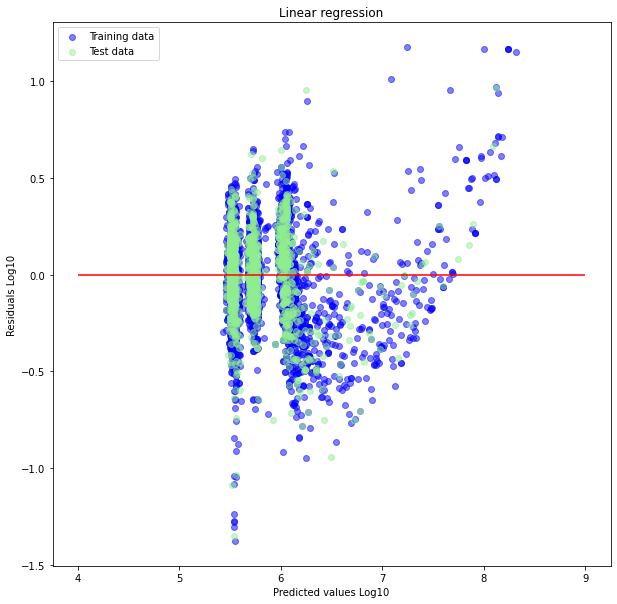

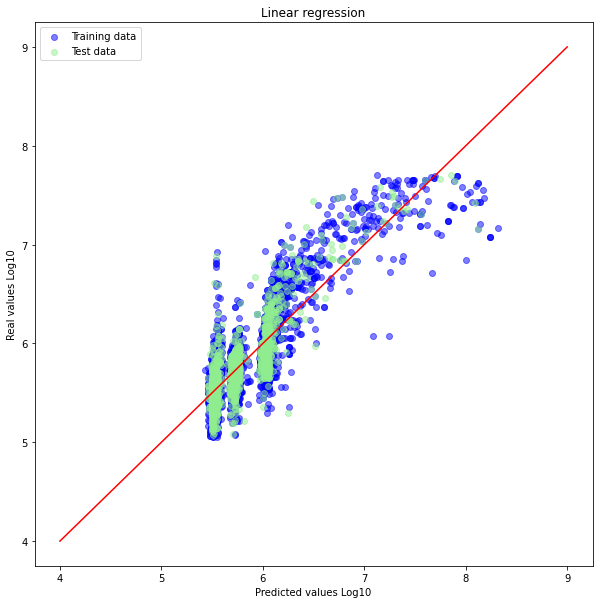

In [20]:
# Plot residuals
plt.figure(figsize=(10, 10))
plt.scatter(Y_train_pred, Y_train_pred - Y_train, c = "blue", marker = "o", alpha=0.5, label = "Training data")
plt.scatter(Y_test_pred, Y_test_pred - Y_test, c = "lightgreen", marker = "o", alpha=0.5, label = "Test data")
plt.title("Linear regression")
plt.xlabel("Predicted values Log10")
plt.ylabel("Residuals Log10")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 4, xmax = 9, color = "red")
plt.show()

# Plot predictions
plt.figure(figsize=(10, 10))
plt.scatter(Y_train_pred, Y_train, c = "blue", marker = "o", alpha=0.5,  label = "Training data")
plt.scatter(Y_test_pred, Y_test, c = "lightgreen", marker = "o", alpha=0.5, label = "Test data")
plt.title("Linear regression")
plt.xlabel("Predicted values Log10")
plt.ylabel("Real values Log10")
plt.legend(loc = "upper left")
plt.plot([4, 9], [4, 9], c = "red")
plt.show()

## Lasso regularization

Now we are going to use regularized linear regression models and pick the best tuning parameter thanks to the cross validation rmse function

In [21]:
# create model
lasso_regressor = Lasso(alpha =0.0005)

In [22]:
# computing cross validation scores
lasso_regression_scores = rmse_cv(lasso_regressor, X_train, Y_train)

print("lasso linear regression : RMSE = {} with a standard deviation of {}".format(lasso_regression_scores.mean(), lasso_regression_scores.std()))

lasso linear regression : RMSE = 0.22999422459785607 with a standard deviation of 0.009843378554292672


In [23]:
# fit the model and predict values from train an validation sets
lasso_regressor.fit(X_train, Y_train)
Y_train_pred = lasso_regressor.predict(X_train)
Y_test_pred = lasso_regressor.predict(X_test)

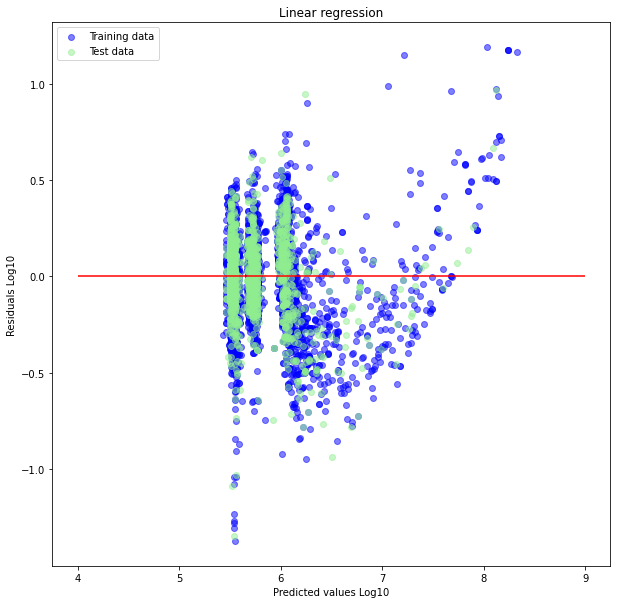

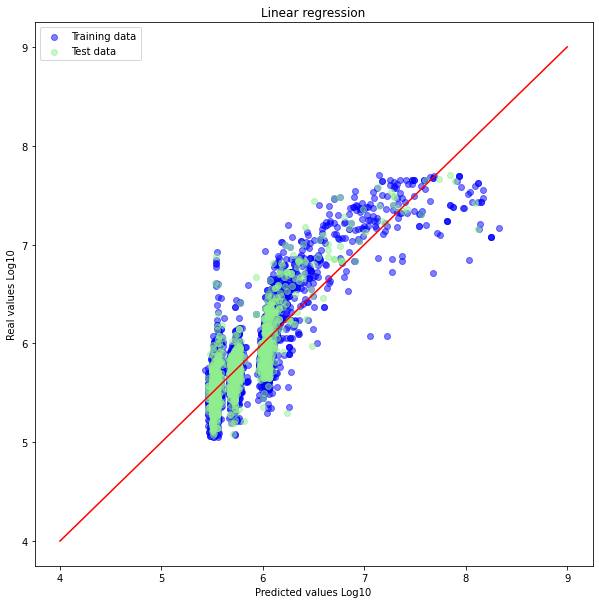

In [24]:
# Plot residuals
plt.figure(figsize=(10, 10))
plt.scatter(Y_train_pred, Y_train_pred - Y_train, c = "blue", marker = "o", alpha=0.5, label = "Training data")
plt.scatter(Y_test_pred, Y_test_pred - Y_test, c = "lightgreen", marker = "o", alpha=0.5, label = "Test data")
plt.title("Linear regression")
plt.xlabel("Predicted values Log10")
plt.ylabel("Residuals Log10")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 4, xmax = 9, color = "red")
plt.show()

# Plot predictions
plt.figure(figsize=(10, 10))
plt.scatter(Y_train_pred, Y_train, c = "blue", marker = "o", alpha=0.5,  label = "Training data")
plt.scatter(Y_test_pred, Y_test, c = "lightgreen", marker = "o", alpha=0.5, label = "Test data")
plt.title("Linear regression")
plt.xlabel("Predicted values Log10")
plt.ylabel("Real values Log10")
plt.legend(loc = "upper left")
plt.plot([4, 9], [4, 9], c = "red")
plt.show()

Text(0, 0.5, 'rmse')

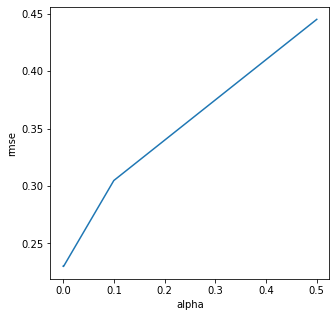

In [25]:
alphas = [0.5, 0.1, 0.001, 0.0005, 0.0001]
cv_lasso = [rmse_cv(Lasso(alpha = alpha), X_train, Y_train).mean() for alpha in alphas]
cv_lasso = pd.Series(cv_lasso, index = alphas)
cv_lasso.plot(figsize=(5, 5))
plt.xlabel("alpha")
plt.ylabel("rmse")

## Ridge regularization

In [26]:
# create model
ridge_regressor = Ridge(alpha =15)

In [27]:
# computing cross validation scores
ridge_regression_scores = rmse_cv(ridge_regressor, X_train, Y_train)

print("ridge linear regression : RMSE = {} with a standard deviation of {}".format(ridge_regression_scores.mean(), ridge_regression_scores.std()))

ridge linear regression : RMSE = 0.23015833276647263 with a standard deviation of 0.010102792221462096


In [28]:
# fit the model and predict values from train an validation sets
ridge_regressor.fit(X_train, Y_train)
Y_train_pred = ridge_regressor.predict(X_train)
Y_test_pred = ridge_regressor.predict(X_test)

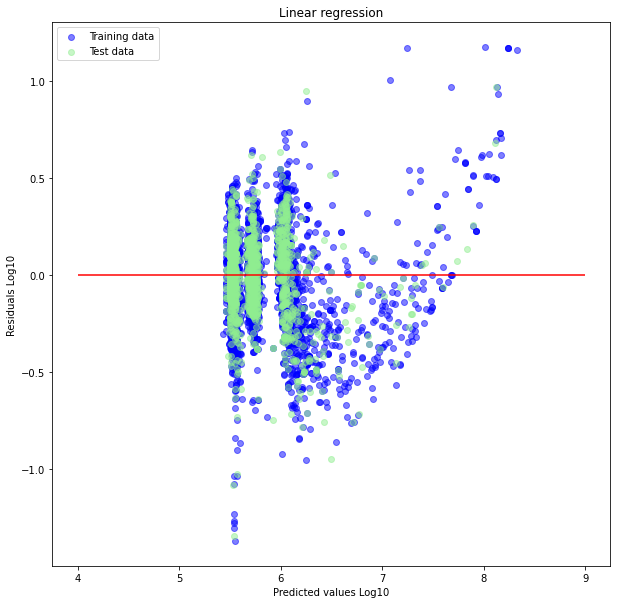

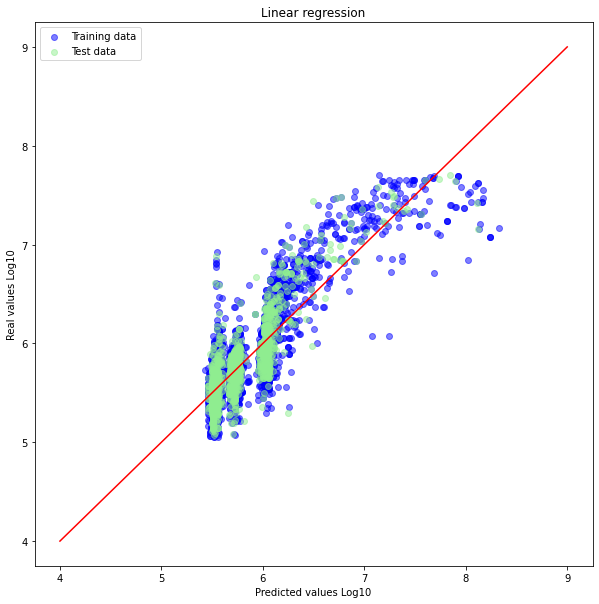

In [29]:
# Plot residuals
plt.figure(figsize=(10, 10))
plt.scatter(Y_train_pred, Y_train_pred - Y_train, c = "blue", marker = "o", alpha=0.5, label = "Training data")
plt.scatter(Y_test_pred, Y_test_pred - Y_test, c = "lightgreen", marker = "o", alpha=0.5, label = "Test data")
plt.title("Linear regression")
plt.xlabel("Predicted values Log10")
plt.ylabel("Residuals Log10")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 4, xmax = 9, color = "red")
plt.show()

# Plot predictions
plt.figure(figsize=(10, 10))
plt.scatter(Y_train_pred, Y_train, c = "blue", marker = "o", alpha=0.5,  label = "Training data")
plt.scatter(Y_test_pred, Y_test, c = "lightgreen", marker = "o", alpha=0.5, label = "Test data")
plt.title("Linear regression")
plt.xlabel("Predicted values Log10")
plt.ylabel("Real values Log10")
plt.legend(loc = "upper left")
plt.plot([4, 9], [4, 9], c = "red")
plt.show()

Text(0, 0.5, 'rmse')

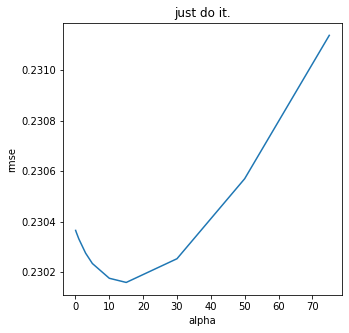

In [30]:
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha), X_train, Y_train).mean() for alpha in alphas]
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(figsize=(5, 5))
plt.title('just do it.')
plt.xlabel("alpha")
plt.ylabel("rmse")

## Random forest regressor

In [34]:
# create model
random_forest_regressor = RandomForestRegressor(
    n_estimators= 300,
    max_depth= 7,
    random_state= 18,
    min_samples_split= 2,
    min_samples_leaf= 4, 
)

In [38]:
# computing cross validation scores
random_forest_regression_scores = rmse_cv(random_forest_regressor, X_train, Y_train)

print(random_forest_regression_scores)

print("random forest regression : RMSE = {} with a standard deviation of {}".format(random_forest_regression_scores.mean(), random_forest_regression_scores.std()))

[0.16316661 0.1695138  0.18973734 0.16017048 0.16916559]
random forest regression : RMSE = 0.17035076221301632 with a standard deviation of 0.010326614083483225


In [36]:
# fit the model with the full train set and predict values for full train an test sets
random_forest_regressor.fit(X_train, Y_train)
Y_train_pred = random_forest_regressor.predict(X_train)
Y_test_pred = random_forest_regressor.predict(X_test)

In [40]:
# score full train set
random_forest_rmse_train = mean_squared_error(Y_train, Y_train_pred, squared=False)
print('train RMSE : ', random_forest_rmse_train)

# score test set
random_forest_rmse_test = mean_squared_error(Y_test, Y_test_pred, squared=False)
print('test RMSE : ', random_forest_rmse_test)

train RMSE :  0.15636087649526206
test RMSE :  0.1645811069317289


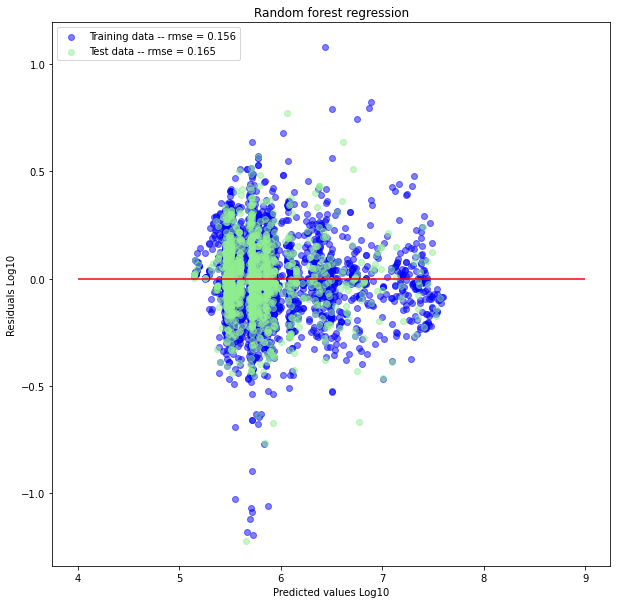

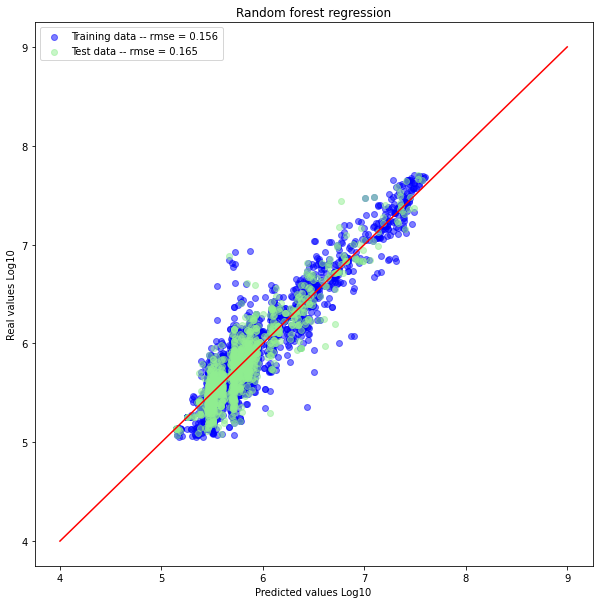

In [53]:
# Plot residuals
plt.figure(figsize=(10, 10))
plt.scatter(Y_train_pred, Y_train_pred - Y_train, c = "blue", marker = "o", alpha=0.5, label = f"Training data -- rmse = {random_forest_rmse_train.round(3)}")
plt.scatter(Y_test_pred, Y_test_pred - Y_test, c = "lightgreen", marker = "o", alpha=0.5, label = f"Test data -- rmse = {random_forest_rmse_test.round(3)}")
plt.title("Random forest regression")
plt.xlabel("Predicted values Log10")
plt.ylabel("Residuals Log10")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 4, xmax = 9, color = "red")
plt.show()

# Plot predictions
plt.figure(figsize=(10, 10))
plt.scatter(Y_train_pred, Y_train, c = "blue", marker = "o", alpha=0.5,  label = f"Training data -- rmse = {random_forest_rmse_train.round(3)}")
plt.scatter(Y_test_pred, Y_test, c = "lightgreen", marker = "o", alpha=0.5, label = f"Test data -- rmse = {random_forest_rmse_test.round(3)}")
plt.title("Random forest regression")
plt.xlabel("Predicted values Log10")
plt.ylabel("Real values Log10")
plt.legend(loc = "upper left")
plt.plot([4, 9], [4, 9], c = "red")
plt.show()

In [48]:
###### Training with hyperparameters optimization #######

# Perform grid search
print("Grid search...")
regressor = RandomForestRegressor()

# Grid of values to be tested
params = {
    'max_depth': [16, 25, 100],
    'min_samples_leaf': [1, 2 , 10],
    'min_samples_split': [4, 8, 12],
    'n_estimators': [100, 140, 200]
}

gridsearch = GridSearchCV(regressor, param_grid = params, cv = 3) # cv : the number of folds to be used for CV
gridsearch.fit(X_train, Y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch.best_params_)
print("Best validation accuracy : ", gridsearch.best_score_)

Grid search...
...Done.
Best hyperparameters :  {'max_depth': 100, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 200}
Best validation accuracy :  0.9085831130323362


In [51]:
print("Best hyperparameters : ", gridsearch.best_params_)
print("Best validation accuracy : ", gridsearch.best_score_)

Best hyperparameters :  {'max_depth': 100, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 200}
Best validation accuracy :  0.9085831130323362


In [28]:
###### Performances ######

# Predictions on training set
print("Predictions on training set...")
Y_train_pred = gridsearch.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

# Predictions on test set
print("Predictions on test set...")
Y_test_pred = gridsearch.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()


Predictions on training set...


NameError: name 'gridsearch' is not defined

In [83]:
# fit a random forest regressor

randomForestRegressor = RandomForestRegressor(n_estimators=200, max_depth=100, min_samples_leaf=1, min_samples_split=4, random_state=0)
randomForestRegressor.fit(X_train, Y_train)

RandomForestRegressor(max_depth=100, min_samples_split=4, n_estimators=200,
                      random_state=0)

In [84]:
# computing RMLSE score for a dumb model that systematically predict the mean target value

mean_value_vector = np.full(len(Y_test), Y_test.mean())
mean_squared_error(y_true = Y_test, y_pred= mean_value_vector ,squared = False)

0.4285822226639252

In [85]:
# with our predictions

y_train_pred = randomForestRegressor.predict(X_train)
y_test_pred = randomForestRegressor.predict(X_test)

mean_squared_error(y_true = Y_test, y_pred= y_test_pred ,squared = False)


0.15820562687690315

In [86]:
# plot feature importance

randomForestRegressor.feature_importances_
sorted_idx = randomForestRegressor.feature_importances_.argsort()
randomForestRegressor.feature_importances_[sorted_idx]
plt.barh(X.columns[sorted_idx], randomForestRegressor.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

IndexError: index 10 is out of bounds for axis 0 with size 7

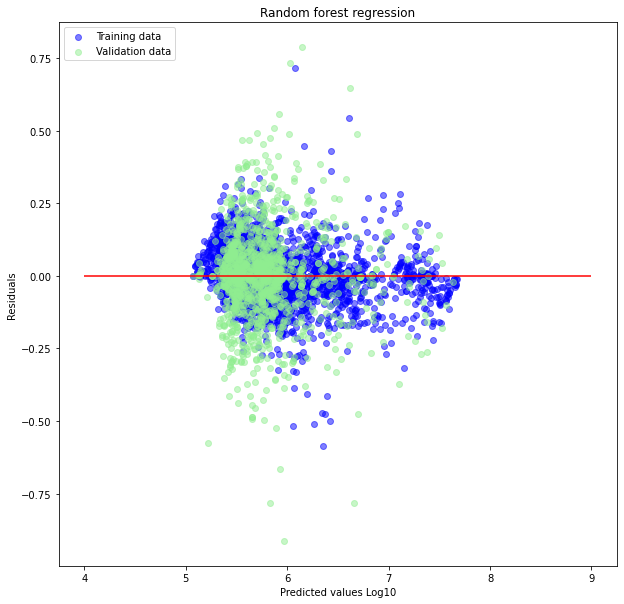

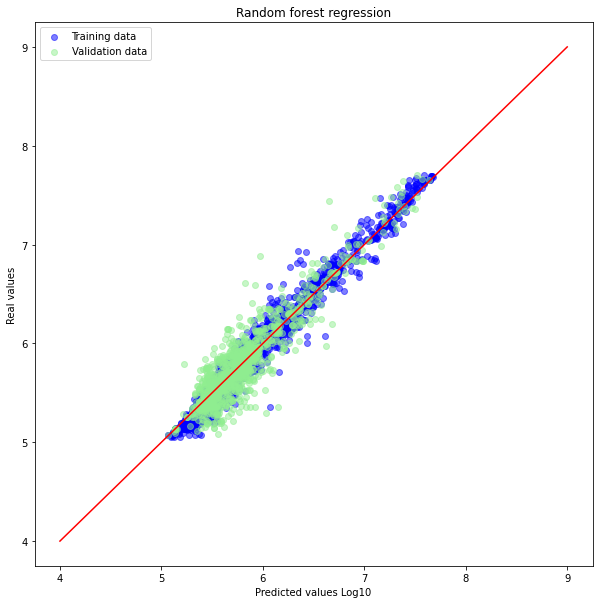

In [87]:
# Plot residuals
plt.figure(figsize=(10, 10))
plt.scatter(y_train_pred, y_train_pred - Y_train, c = "blue", marker = "o", alpha=0.5, label = "Training data")
plt.scatter(y_test_pred, y_test_pred - Y_test, c = "lightgreen", marker = "o", alpha=0.5, label = "Validation data")
plt.title("Random forest regression")
plt.xlabel("Predicted values Log10")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 4, xmax = 9, color = "red")
plt.show()

# Plot predictions
plt.figure(figsize=(10, 10))
plt.scatter(y_train_pred, Y_train, c = "blue", marker = "o", alpha=0.5,  label = "Training data")
plt.scatter(y_test_pred, Y_test, c = "lightgreen", marker = "o", alpha=0.5, label = "Validation data")
plt.title("Random forest regression")
plt.xlabel("Predicted values Log10")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([4, 9], [4, 9], c = "red")
plt.show()

In [47]:
###### Training with hyperparameters optimization #######

# Perform grid search
print("Grid search...")
regressor = xgb.XGBRegressor()

# Grid of values to be tested
params = {
    'n_estimators': [400, 700, 1000],
    'colsample_bytree': [0.7, 0.8],
    'max_depth': [15,20,25],
    'reg_alpha': [1.1, 1.2, 1.3],
    'reg_lambda': [1.1, 1.2, 1.3],
    'subsample': [0.7, 0.8, 0.9]
}

gridsearch = GridSearchCV(regressor, param_grid = params, cv = 3) # cv : the number of folds to be used for CV
gridsearch.fit(X_train, Y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch.best_params_)
print("Best validation accuracy : ", gridsearch.best_score_)

Grid search...
...Done.
Best hyperparameters :  {'colsample_bytree': 0.8, 'max_depth': 25, 'n_estimators': 400, 'reg_alpha': 1.2, 'reg_lambda': 1.1, 'subsample': 0.7}
Best validation accuracy :  0.9064001962272465


In [48]:
print("Best hyperparameters : ", gridsearch.best_params_)
print("Best validation accuracy : ", gridsearch.best_score_)

Best hyperparameters :  {'colsample_bytree': 0.8, 'max_depth': 25, 'n_estimators': 400, 'reg_alpha': 1.2, 'reg_lambda': 1.1, 'subsample': 0.7}
Best validation accuracy :  0.9064001962272465


In [63]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.8, gamma=0.4, 
                             learning_rate=0.1, max_depth=25, 
                             min_child_weight=1.5, n_estimators=400,
                             reg_alpha=1.2, reg_lambda=1.1,
                             subsample=0.7, silent=1,
                             random_state =0, nthread = -1)
model_xgb.fit(X_train, Y_train)

[11:33:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0.4, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=25, max_leaves=0, min_child_weight=1.5,
             missing=nan, monotone_constraints='()', n_estimators=400,
             n_jobs=-1, nthread=-1, num_parallel_tree=1, predictor='auto',
             random_state=0, reg_alpha=1.2, ...)

In [64]:
# with our predictions

y_train_pred = model_xgb.predict(X_train)
y_test_pred = model_xgb.predict(X_test)

mean_squared_error(y_true = Y_test, y_pred= y_test_pred, squared = False)

0.14298490748557094

Text(0.5, 0, 'XGBoost Feature Importance')

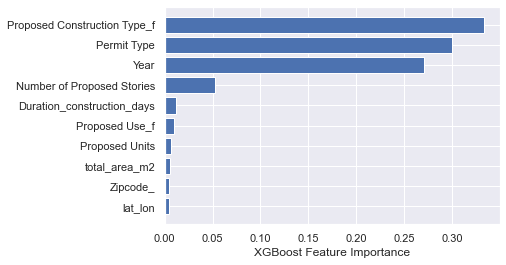

In [65]:
# plot feature importance

model_xgb.feature_importances_
sorted_idx = model_xgb.feature_importances_.argsort()
model_xgb.feature_importances_[sorted_idx]
plt.barh(X.columns[sorted_idx], model_xgb.feature_importances_[sorted_idx])
plt.xlabel("XGBoost Feature Importance")

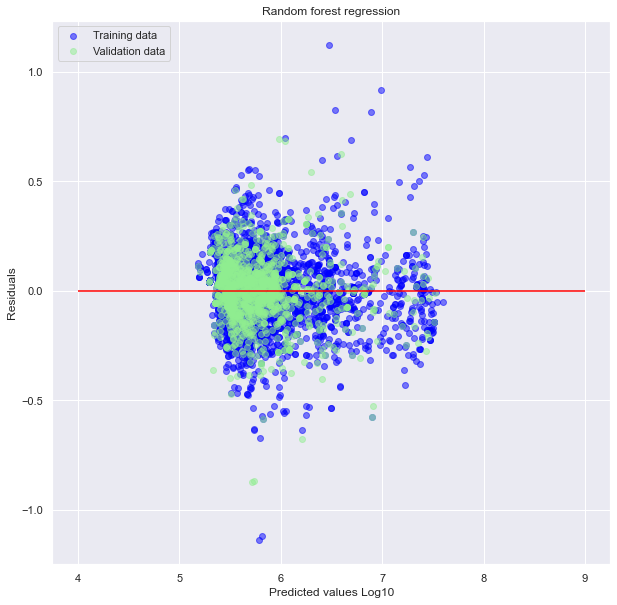

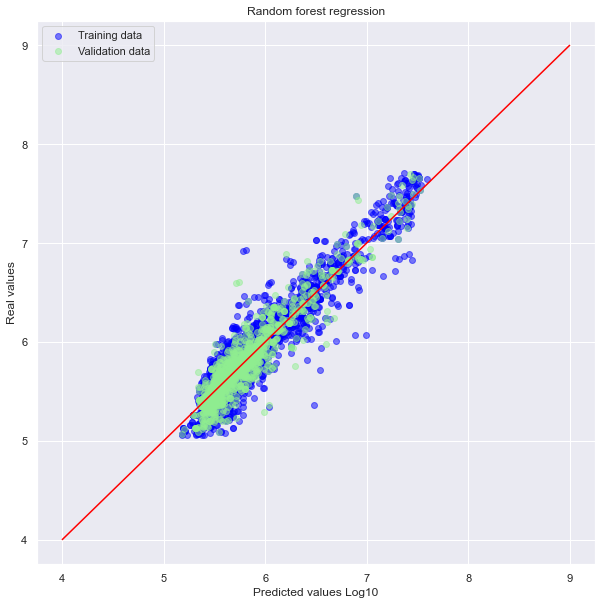

In [58]:
# Plot residuals
plt.figure(figsize=(10, 10))
plt.scatter(y_train_pred, y_train_pred - Y_train, c = "blue", marker = "o", alpha=0.5, label = "Training data")
plt.scatter(y_test_pred, y_test_pred - Y_test, c = "lightgreen", marker = "o", alpha=0.5, label = "Validation data")
plt.title("Random forest regression")
plt.xlabel("Predicted values Log10")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 4, xmax = 9, color = "red")
plt.show()

# Plot predictions
plt.figure(figsize=(10, 10))
plt.scatter(y_train_pred, Y_train, c = "blue", marker = "o", alpha=0.5,  label = "Training data")
plt.scatter(y_test_pred, Y_test, c = "lightgreen", marker = "o", alpha=0.5, label = "Validation data")
plt.title("Random forest regression")
plt.xlabel("Predicted values Log10")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([4, 9], [4, 9], c = "red")
plt.show()

In [44]:
print("Preprocessing X...")
print()
X = preprocessor.fit_transform(X)
print("...Done!")


Preprocessing X...

...Done!


In [47]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.8, gamma=0.4, 
                             learning_rate=0.1, max_depth=25, 
                             min_child_weight=1.5, n_estimators=400,
                             reg_alpha=1.2, reg_lambda=1.1,
                             subsample=0.7, silent=1,
                             random_state =0, nthread = -1)

randomForestRegressor = RandomForestRegressor(n_estimators=200, max_depth=100, min_samples_leaf=1, min_samples_split=4, random_state=0)


In [53]:
description_ML = "dataset V8 | result XGBoost and RandomForestRegressor | Baptiste" #include why you do this experiment

#Other variables
n_folds = 4
random_state = 0


###We can delete the functions below, we defined a function called cross_validation_score in functions.py
#R2
"""
def R2_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=random_state).get_n_splits(X)
    R2= cross_val_score(model, X, Y, scoring="r2", cv = kf)
    return(R2)

#sqrt of negative mean squared error
def rmse_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=random_state).get_n_splits(X)
    rmse= np.sqrt(-cross_val_score(model, X, Y, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

#sqrt of negative mean squred log error
def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=random_state).get_n_splits(X)
    rmsle= np.sqrt(-cross_val_score(model, X, Y, scoring="neg_mean_squared_log_error", cv = kf))
    return(rmsle)

#Mean absolute percentage error*
def mape_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=random_state).get_n_splits(X)
    mape= -cross_val_score(model, X, Y, scoring="neg_mean_absolute_percentage_error", cv = kf)
    return(mape)

#explained_variance_score 
def evs_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=random_state).get_n_splits(X)
    evs= cross_val_score(model, X, Y, scoring="explained_variance", cv = kf)
    return(evs)
"""

In [54]:
models = [
          model_xgb,
          #model_lgb,
          randomForestRegressor
          ]

model_names = [
               "\nXGBoost\n",
               #"\nLGBM model\n",
               "\nRandom Forest Regressor"
               ]

In [55]:
count = 0
for model in models :
  print("\n**********"+model_names[count]+"**********")
  print("**********Scores on test set**********\n")
  cv_scores = cross_validate_score (model, n_folds, random_state, X_train, Y_train)
  score_1 = cv_scores['test_r2']
  print("R2 score - mean : {:.4f}  |  std : {:.4f}\n".format(score_1.mean(), score_1.std()))

  score_2 = np.sqrt(-cv_scores['test_neg_mean_squared_error'])
  print("\nRoot mean squared error - mean : {:.4f}  |  std : {:.4f}\n".format(score_2.mean(), score_2.std()))

  score_3 = np.sqrt(-cv_scores['test_neg_mean_squared_log_error'])
  print("\nRMSLE -logarithmic error - mean : {:.4f}  |  std : {:.4f}\n".format(score_3.mean(), score_3.std()))

  score_4 = -cv_scores["test_neg_mean_absolute_percentage_error"]
  print("\nMean absolute percentage error - mean : {:.3f}  |  std : {:.3f}\n".format(score_4.mean(), score_4.std()))

  score_5 = cv_scores["test_explained_variance"]
  print("\nExplained variance score - mean : {:.4f}  |  std : {:.4f}\n".format(score_5.mean(), score_5.std()))
  print("----------------END--------------------")
  count = count + 1
  score_ML_log(fname1 = dataset_url, 
               dataset, model, target_variable, categorical_features, numeric_features,
               description_ML, n_folds, random_state,
               score_1, score_2, score_3, score_4, score_5, 
               flog = "../Tracking/exp_logs.csv")


XGBoost

[12:09:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[12:09:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[12:09:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could 

In [61]:
#fit the final model

randomForestRegressor.fit(X,Y)

RandomForestRegressor(max_depth=100, min_samples_split=4, n_estimators=200,
                      random_state=0)

In [62]:
# Save Model Using joblib


# save the model to disk
filename_model = '../Docker/finalmodel.joblib'
joblib.dump(randomForestRegressor, filename_model)

#save preprocessor to disk
filename_preprocessor = '../Docker/finalprepro.joblib'
joblib.dump(preprocessor, filename_preprocessor)

 
# some time later...
 
# load the model from disk
#loaded_model = joblib.load(filename)
#result = loaded_model.score(X_test, Y_test)
#print(result)

['finalprepro.jolib']

In [63]:
# load the model from disk
loaded_model = joblib.load('finalmodel.jolib')
result = loaded_model.score(X, Y)
print(result)

0.9851773947910737
